In [1]:
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from src.chemkin_wrapper import chemkin_wrapper, plot_outputs
from src.chemkin import CHEMKIN 
from src.hychem import CONDITION, HYCHEM_A2, x_to_params, params_to_x

%reload_ext autoreload
%autoreload 2

In [2]:
np.random.seed(9123)

hc = HYCHEM_A2("../data/cheminp", "../workingdir", CHEMKIN("../workingdir"))
cond = CONDITION(1300, 4, {'POSF10325': .004, 'AR': .996})
print(cond)

true_x = np.random.rand(27)
hc.write_cheminp(true_x)
true_d = hc.simulate(cond).loc[:, ["t", "POSF10325", "CH4", "C2H4", "C3H6"]]
print(true_d.head())

iter_x = np.random.rand(27)
hc.loss(iter_x, true_d, cond)**0.5
hc.grad(range(15))

Temperature: 1300 K
Pressure: 4 atm
POSF10325: 0.004 (fraction)
AR: 0.996 (fraction)

        t  POSF10325       CH4      C2H4      C3H6
0  0.0000   0.004000  0.000000  0.000000  0.000000
1  1.0850   0.003733  0.000093  0.000094  0.000190
2  2.1746   0.003501  0.000175  0.000175  0.000353
3  3.1651   0.003315  0.000244  0.000241  0.000484
4  4.1557   0.003146  0.000307  0.000301  0.000603


array([-3.70257619e-07, -2.84537790e-08, -9.96592153e-08, -7.51943473e-07,
       -2.06796305e-07,  3.16557064e-09, -1.70318461e-07, -1.68606315e-08,
        8.75490764e-07, -3.39151218e-08, -1.43830017e-06,  2.90026149e-09,
       -7.24419096e-11, -4.79260911e-09,  6.11924732e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

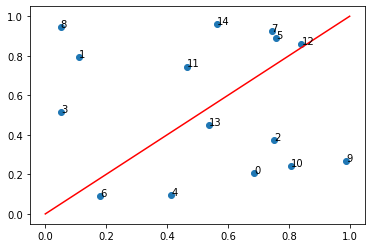

epoch 0
		exp 2 loss 0.003214421298163367
		exp 1 loss 2.076146363573168
		exp 0 loss 2.2584612924718095
epoch 1
		exp 0 loss 2.2584612924718095
		exp 2 loss 2.2278407917413388
		exp 1 loss 2.0756632630429723
epoch 2
		exp 2 loss 2.2278407917413388


KeyboardInterrupt: 

In [3]:
np.random.seed(39123)
hc = HYCHEM_A2("../data/cheminp", "../workingdir", CHEMKIN("../workingdir"))
true_x = np.random.rand(27)
Ts = [1100, 1200, 1300]
n_exp = len(Ts)
conds = []
dfs = []
for i in range(len(Ts)):
    cond = CONDITION(Ts[i], 4, {'POSF10325': .004, 'AR': .996})
    conds.append(cond)
    hc.write_cheminp(true_x)
    true_d = hc.simulate(cond).loc[:, ["t", "POSF10325", "CH4", "C2H4", "C3H6", "iC4H8"]]
    dfs.append(true_d)

iter_x = np.random.rand(27)

momentum = np.zeros_like(iter_x)

n_idx = 15
plt.plot(iter_x[range(n_idx)], true_x[range(n_idx)], 'o')
for i in range(n_idx):
    plt.text(iter_x[i], true_x[i], i)
plt.plot([0, 1], [0, 1], 'r-')
plt.show()
n_epoch = 10
iter_x_hist = np.zeros((n_epoch*n_exp*n_idx, n_idx))
loss_hist = np.zeros(n_epoch*n_exp)
iter = 0
for epoch in range(n_epoch):
    print(f"epoch {epoch}")
    last_iter_x = iter_x.copy()
    # iter_x += epoch/(epoch+3)*momentum
    for i_exp in np.random.permutation(n_exp):
        alpha = 1e3/(1+iter)**0.5  # step size
        cond, true_d = conds[i_exp], dfs[i_exp]
        loss_hist[iter] = loss = hc.loss(iter_x, true_d, cond)**0.5
        
        count = 0
        print(f"\t\texp {i_exp}")
        for i in np.random.permutation(n_idx):
            iter_x_hist[iter*n_idx+count] = iter_x[range(n_idx)]
            count += 1
            gi = hc.grad([i])
            iter_x -= alpha*gi
            iter_x[iter_x>1] = 1
            iter_x[iter_x<0] = 0
            change = np.linalg.norm(alpha*gi, 1)
            print(f"\t\t\tloss {loss} change {change}")
        
        iter += 1
    momentum = iter_x - last_iter_x

In [ ]:
plt.plot(iter_x[range(n_idx)], true_x[range(n_idx)], 'o');
for i in range(n_idx):
    plt.text(iter_x[i], true_x[i], i)
plt.plot([0, 1], [0, 1], 'r-');

In [ ]:
plt.plot(iter_x_hist);
plt.ylim([0, 1])

In [ ]:
plt.plot(loss_hist, "-o");
plt.yscale("log")

In [ ]:
hc.grad(range(n_idx))

In [4]:
gi

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.])